In [1]:
import os
import zipfile
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


In [2]:
# Define the path and split your data into training and validation split
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:/Users/TEE/Documents/The IQ-OTHNCCD lung cancer dataset")
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:/Users/TEE/Documents/The IQ-OTHNCCD lung cancer dataset", validation_split=0.2, subset="training", seed=123)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:/Users/TEE/Documents/The IQ-OTHNCCD lung cancer dataset", validation_split=0.2, subset="validation", seed=123)

Found 2194 files belonging to 4 classes.
Found 2194 files belonging to 4 classes.
Using 1756 files for training.
Found 2194 files belonging to 4 classes.
Using 438 files for validation.


In [15]:
import os
import pandas as pd

# Define dataset root directory
dataset_root = r"C:/Users/TEE/Documents/The IQ-OTHNCCD lung cancer dataset"

# Expected subdirectory names
expected_classes = ["Malignant cases", "Benign cases", "Normal cases"]

filepaths = []
labels = []

# Loop through each expected class folder
for label in expected_classes:
    class_dir = os.path.join(dataset_root, label)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        flist = os.listdir(class_dir)
        for f in flist:
            fpath = os.path.join(class_dir, f)
            if os.path.isfile(fpath):  # Ensure it's a file
                filepaths.append(fpath)
                labels.append(label)  # Use the folder name as the label
    else:
        print(f"Warning: Expected class folder '{label}' not found in the dataset root.")

# Create DataFrame
lung_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Print dataset summary
print(f"Dataset contains {len(lung_df)} samples.")
print(lung_df.head())
print("\nClass distribution:")
print(lung_df['labels'].value_counts())


Dataset contains 977 samples.
                                           filepaths           labels
0  C:/Users/TEE/Documents/The IQ-OTHNCCD lung can...  Malignant cases
1  C:/Users/TEE/Documents/The IQ-OTHNCCD lung can...  Malignant cases
2  C:/Users/TEE/Documents/The IQ-OTHNCCD lung can...  Malignant cases
3  C:/Users/TEE/Documents/The IQ-OTHNCCD lung can...  Malignant cases
4  C:/Users/TEE/Documents/The IQ-OTHNCCD lung can...  Malignant cases

Class distribution:
Malignant cases    561
Normal cases       416
Name: labels, dtype: int64


In [16]:
Lung_df.shape

(120, 2)

In [17]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [18]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(96, 2)
(36, 2)
(24, 2)
(84, 2)


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define the ImageDataGenerator with preprocessing function
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 96 validated image filenames belonging to 1 classes.
Found 36 validated image filenames belonging to 1 classes.
Found 24 validated image filenames belonging to 1 classes.


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset paths and preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Flow from DataFrame (Ensure train_set is properly prepared beforehand)
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=True
)

# Print the class indices
classes = list(train.class_indices.keys())
print("Classes:", classes)


Found 96 validated image filenames belonging to 1 classes.
Classes: ['benign']


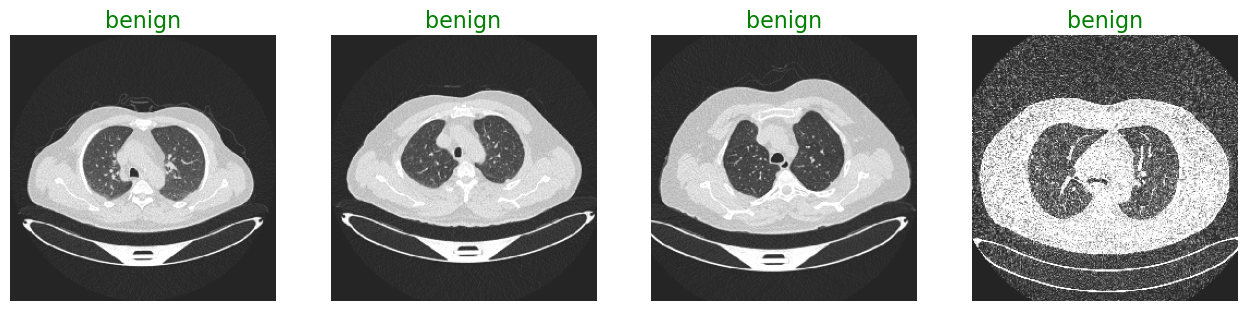

In [37]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [38]:
import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

C:\Users\TEE\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 6, 6, 512)      │         2,04

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [47]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/3e/1b/ef569ac44598b6b24bc0f80d5ac4f811af59d3f0d0d23b0216e014c0ec33/pydot-3.0.3-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [49]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [41]:
# Correct the model compilation to use sparse_categorical_crossentropy
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # This works with integer labels
    metrics=['accuracy']
)

# Now fit the model with integer labels
history = model.fit(
    train,  # Assuming 'train' is a generator or dataset object
    epochs=10,
    validation_data=val,  # Assuming 'val' is a generator or dataset object
    verbose=1
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.8855 - loss: 0.4054 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 575ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 606ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 604

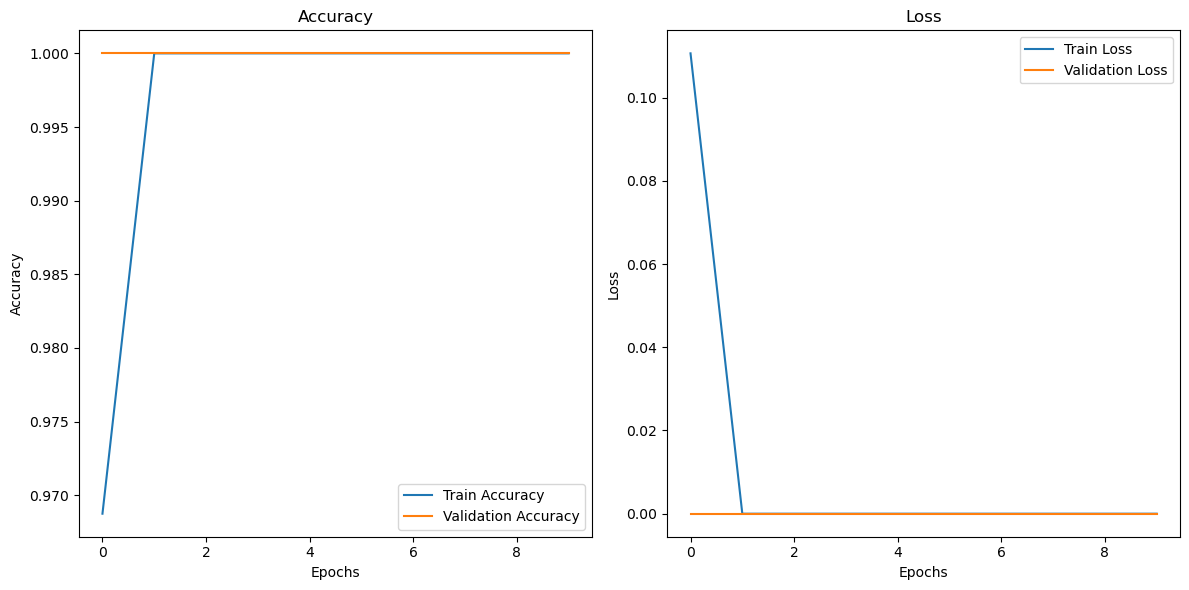

In [42]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
# For example: history = model.fit(train, epochs=10, validation_data=val)

# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()
